In [1]:
"""Metric Learning."""

import datetime
from ast import literal_eval
from types import MethodType

import boto3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
from pytorch_metric_learning import distances, losses, miners, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.nn import TripletMarginLoss
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

from playlist_selection.logging_config import get_logger

LOGGER = get_logger("root")
RANDOM_STATE = 42

In [2]:
session = boto3.Session(profile_name="project")
client = session.client("s3")

bucket = "hse-project-playlist-selection"
dataset_key = "dataset/filtered_data_30_11_23.csv"

body = client.get_object(Bucket=bucket, Key=dataset_key)["Body"]
df = pd.read_csv(body, index_col=0)

for column in "genres", "artist_name":
    df[column] = df[column].apply(literal_eval)

df.dropna(inplace=True)
df["album_release_date"] = pd.to_datetime(df["album_release_date"], format="mixed")
df = df.reset_index(drop=True)

df.head(1).T

2024-02-25 12:16:40,991 - botocore.credentials - INFO - Found credentials in shared credentials file: ~/.aws/credentials
2024-02-25 12:16:41,045 - botocore.configprovider - INFO - Found endpoint for s3 via: config_global.


,0
key,61_HighwayCorey_Harris
genre,acoustic
audio_path,tracks/acoustic/61_HighwayCorey_Harris/audio.mp3
album_name,Between Midnight And Day
album_id,6fuRNpnOE7QgyT1IcdvpED
album_release_date,1995-10-31 00:00:00
artist_name,[Corey Harris]
artist_id,['1TQtbRQbaXw5CeN3mC0DJH']
track_id,3zGcBpopIzVBqqHRoRTCR2
track_name,61 Highway


# *Фичи

Для эксперимента возьмём просто числовые фичи из меты. Позже вместо них будем использовать эмбединги.

In [3]:
DROP_COLUMNS = [
    "diff_sec",
    "file_size_mb",
    "duration_ms",
]

def get_numeric_features(dataset: pd.DataFrame) -> list[str]:
    """Extract numeric features list from dataset."""
    idx = (dataset.select_dtypes(np.number).sample(50, random_state=RANDOM_STATE).nunique() == 50).index
    numeric_columns = dataset.loc[:, idx].select_dtypes(np.number).columns
    numeric_columns = numeric_columns.drop(labels=DROP_COLUMNS).tolist()
    return numeric_columns

numeric_features = get_numeric_features(df)
for numeric_feature in numeric_features:
    df[numeric_feature] = df[numeric_feature].astype(float)
df.loc[:, numeric_features].head(1)


,popularity,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,valence,tempo,...,sections_mean_time_signature,segments_number,segments_mean_duration,segments_mean_pitch,segments_max_pitch,segments_min_pitch,segments_mean_timbre,segments_max_timbre,segments_min_timbre,real_duration_ms
0,5.0,0.637,0.0229,-22.846,1.0,0.044,0.907,0.000145,0.226,80.923,...,4.0,780.0,0.318523,0.255563,1.0,0.0398,-5.691454,66.999615,-89.520079,288578.0


# Torch Dataset

In [18]:
pd.options.mode.chained_assignment = None

def get_positive_and_negative_objects(dataset: pd.DataFrame, anchor: pd.Series) -> tuple[int, int]:
    """Sample positive and negative object for anchor."""
    
    def get_intersection_score(other: list[str], anchor: list[str]) -> float:
        if len(anchor) == 0:
            return 0
        intersection = set(other) & set(anchor)
        score = len(intersection) / len(set(anchor))
        return score

    def get_realese_year_score(other: datetime.date, anchor: datetime.date):
        other = pd.to_datetime(other)
        anchor = pd.to_datetime(anchor)
        diff = abs(other.year - anchor.year) / 30 # ?
        return 1 - np.clip(diff, 0, 1)
    
    dataset = dataset.loc[dataset.index != anchor.name, :]

    genre_score = dataset["genre"] == anchor["genre"]
    artist_name_score = dataset["artist_name"].apply(get_intersection_score, args=(anchor["artist_name"], ))
    genres_score = dataset["genres"].apply(get_intersection_score, args=(anchor["genres"], ))
    album_release_date_score = dataset["album_release_date"].apply(
        get_realese_year_score, args=(anchor["album_release_date"], )
    )

    final_score = (
        0.5 * genre_score
        + 0.3 * genres_score
        + 0.15 * artist_name_score
        + 0.3 * album_release_date_score
    )

    dataset.loc[:, "final_score"] = final_score
    dataset = dataset.sort_values("final_score")
    positive_dataset = dataset.iloc[-50:, :]

    positive_track = positive_dataset.sample()
    
    # тут нужно делать умнее
    # negative_track = dataset.iloc[len(dataset) // 2:2 * len(dataset) // 3, :].sample()
    negative_track = dataset.iloc[:len(dataset) // 2, :].sample()
    
    LOGGER.debug(
        "anchor - %s, positive - %s, negative - %s.",
        anchor["key"], positive_track["key"].iloc[0], negative_track["key"].iloc[0]
    )

    return positive_track.index[0], negative_track.index[0]


class AudioDataset(Dataset):
    """Dataset for audio features."""
    
    def __init__(
        self, 
        df: pd.DataFrame,
        numeric_features: list[str] = numeric_features,
        return_triplets: bool = True,
        target_column: str = "target",
    ):
        """DF - dataframe with audio metadata."""
        self.df = df
        self.return_triplets = return_triplets
        self.target_column = target_column
        self.numeric_features = numeric_features
        
    def __len__(self) -> int:
        """Size of dataset."""
        return self.df.shape[0]
        
    def __getitem__(self, anchor_index: int) -> torch.tensor:
        """Index - id (?) of anchor track."""
        anchor_sample = self.df.iloc[anchor_index, :]
        if not self.return_triplets:
            x = torch.from_numpy(anchor_sample.loc[self.numeric_features].to_numpy(dtype="float32"))
            try:
                y = torch.from_numpy(anchor_sample.loc[[self.target_column]].to_numpy(dtype="int")).squeeze(0)
            except:
                y = anchor_sample.loc[self.target_column]
            return x, y
            
        
        positive_index, negative_index = get_positive_and_negative_objects(self.df, anchor_sample)
        
        anchor_sample = torch.from_numpy(anchor_sample.loc[self.numeric_features].to_numpy(dtype="float32"))
        positive_sample = torch.from_numpy(self.df.loc[positive_index, self.numeric_features].to_numpy(dtype="float32"))
        negative_sample = torch.from_numpy(self.df.loc[negative_index, self.numeric_features].to_numpy(dtype="float32"))

        return {
            "anchor": anchor_sample,
            "positive": positive_sample,
            "negative": negative_sample,
        }

def split_train_val(
    df: pd.DataFrame,
    test_size: float,
    batch_size: int,
    num_workers: int = 1,
    stratify: pd.Series | None = None,
    random_state: int | None = None,
    **dataset_kwargs,
):
    """Split dataset, create dataloaders."""
    train_df, val_df = train_test_split(df, test_size=test_size, stratify=stratify, random_state=random_state)

    train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)

    train_dataset = AudioDataset(df=train_df, **dataset_kwargs)
    val_dataset = AudioDataset(df=val_df, **dataset_kwargs)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    
    return train_dataset, train_loader, val_dataset, val_loader

In [5]:
def get_sample_by_artist(df: pd.DataFrame, artist_name: str, random_state: int | None = None) -> pd.Series:
    """Return sample for artist."""
    mask = df["artist_name"].apply(lambda x: any(y.lower() == artist_name.lower() for y in x))
    target_samples = df.loc[mask]
    if len(target_samples) == 0:
        LOGGER.warning("empty target samples for artist %s.", artist_name)
        return
    sample = target_samples.sample(1, random_state=random_state).iloc[0]
    return sample 

df.get_sample_by_artist = MethodType(get_sample_by_artist, df)
sample = df.get_sample_by_artist("Gunna", random_state=RANDOM_STATE)

n_samples_to_show = 5
for i in range(1, n_samples_to_show + 1):
    if sample is None:
        continue
    
    result = pd.concat([sample.to_frame().T, df.iloc[list(get_positive_and_negative_objects(df, sample))]])
    print("="*20, f"example {i}", "="*20)
    for label, (_, row) in zip(["anchor", "positive", "negative"], result.iterrows()):
        print(label, "-", row["track_name"], row["artist_name"], row["genres"])

==================== example 1 ====================
anchor - DOLLAZ ON MY HEAD (feat. Young Thug) ['Gunna', 'Young Thug'] ['atl hip hop', 'melodic rap', 'rap', 'trap']
positive - Gangsta Music ['Jeezy'] ['atl hip hop', 'crunk', 'dirty south rap', 'gangster rap', 'old school atlanta hip hop', 'rap', 'southern hip hop', 'trap']
negative - Shake That Body - Mike's Vocal Mixx ['Mike Dunn', 'MD III'] ['chicago house', 'classic house', 'deep house']


==================== example 2 ====================
anchor - DOLLAZ ON MY HEAD (feat. Young Thug) ['Gunna', 'Young Thug'] ['atl hip hop', 'melodic rap', 'rap', 'trap']
positive - Outta Time (feat. Drake) ['Bryson Tiller', 'Drake'] ['kentucky hip hop', 'r&b', 'rap']
negative - 害怕 ['Stefanie Sun'] ['mandopop', 'singaporean mandopop', 'singaporean pop', 'singaporean singer-songwriter']
==================== example 3 ====================
anchor - DOLLAZ ON MY HEAD (feat. Young Thug) ['Gunna', 'Young Thug'] ['atl hip hop', 'melodic rap', 'rap', 'trap']
positive - WHATS POPPIN ['Jack Harlow'] ['deep underground hip hop', 'kentucky hip hop', 'pop rap', 'rap']
negative - Alkaholik ['Xzibit'] ['detroit hip hop', 'g funk', 'gangster rap', 'hardcore hip hop', 'hip hop', 'west coast rap']
==================== example 4 ====================
anchor - DOLLAZ ON MY HEAD (feat. Young Thug) ['Gunna', 'Young Thug'] ['atl hip hop', 'melodic rap', 'rap', 'trap']
positive - Visions ['Wiz Khalifa'] ['hip hop

# Модель

In [6]:
class Network(nn.Module):
    def __init__(self, input_size=len(numeric_features), embedding_size=256):
        super(Network, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, embedding_size)
        )
        
    def forward(self, x):
        x = self.fc(x)
        return x


class NetworkBN(nn.Module):
    def __init__(self, input_size=len(numeric_features), embedding_size=256):
        super(NetworkBN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, embedding_size),
        )
        
    def forward(self, x):
        x = self.fc(x)
        return x

# Пробуем что-то обучить

In [7]:
BATCH_SIZE = 64
EMBEDDING_SIZE = 256
LR = 0.001
MARGIN = 3

train_dataset, train_loader, val_dataset, val_loader = split_train_val(
    df=df,
    test_size=0.4,
    batch_size=BATCH_SIZE,
    stratify=df["genre"],
    random_state=RANDOM_STATE,
    num_workers=4,
)

model = Network(input_size=len(numeric_features), embedding_size=EMBEDDING_SIZE)

optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = TripletMarginLoss(margin=MARGIN)

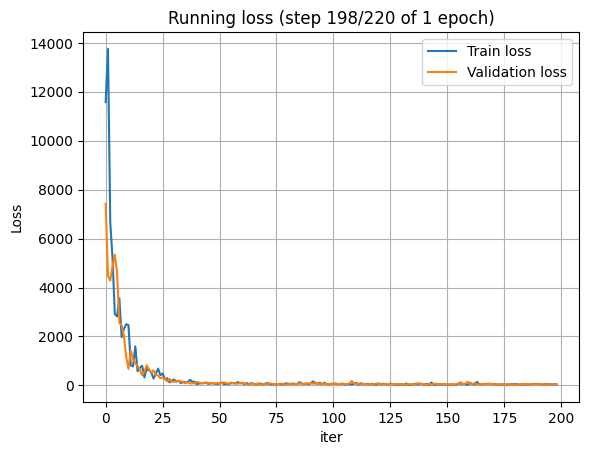

KeyboardInterrupt: 

In [8]:
PLOT = True
DEVICE = "cpu"
EPOCHS = 1

model.train()
for epoch in tqdm(range(EPOCHS), desc="Epochs"):
    running_loss = []
    val_running_loss = []
    for step, objects in enumerate(tqdm(train_loader, desc="Training", leave=False)):
        
        optimizer.zero_grad()
        anchor_out = model(objects["anchor"])
        positive_out = model(objects["positive"])
        negative_out = model(objects["negative"])
        
        loss = criterion(anchor_out, positive_out, negative_out)
        loss.backward()
        optimizer.step()
        running_loss.append(loss.cpu().detach().numpy().tolist())
        
        with torch.no_grad():
            model.eval()
            val_objects = next(iter(val_loader))

            val_anchor_out = model(val_objects["anchor"])
            val_positive_out = model(val_objects["positive"])
            val_negative_out = model(val_objects["negative"])

            val_loss = criterion(val_anchor_out, val_positive_out, val_negative_out)
            val_running_loss.append(val_loss.cpu().detach().numpy().tolist())
            model.train()
        
        if PLOT:
            clear_output(wait=True)
            fig, ax = plt.subplots(1, 1)
            sns.lineplot(x=range(len(running_loss)), y=running_loss, ax=ax, label="Train loss")
            sns.lineplot(x=range(len(val_running_loss)), y=val_running_loss, ax=ax, label="Validation loss")
            ax.grid(True)
            ax.legend()
            ax.set_xlabel("iter")
            ax.set_ylabel("Loss")
            ax.set_title(f"Running loss (step {step}/{len(train_loader)} of {epoch + 1} epoch)")
            plt.show()

    LOGGER.info("Epoch: %s/%s - Loss: %s", epoch+1, EPOCHS, np.mean(running_loss))

### Примеры

In [9]:
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances

model.eval()

val_df = val_dataset.df
val_df.get_sample_by_artist = MethodType(get_sample_by_artist, val_df)
sample = val_df.get_sample_by_artist("Playboi Carti", random_state=RANDOM_STATE)

n_samples_to_show = 5
for i in range(1, n_samples_to_show + 1):
    if sample is None:
        continue
    
    objects = df.iloc[list(get_positive_and_negative_objects(df, sample))]
    result = pd.concat([sample.to_frame().T, objects])
    
    embedding = model(torch.from_numpy(result[numeric_features].to_numpy(dtype="float32")))

    cosine_sim = cosine_similarity(embedding.detach().numpy()).tolist()
    euclidian_diff = pairwise_distances(embedding.detach().numpy()).tolist()

    print("="*20, f"example {i}", "="*20)
    i = 0
    for label, (_, row) in zip(["anchor", "positive", "negative"], result.iterrows()):
        print(label, "-", row["track_name"], row["artist_name"][:3], row["genres"][:3], f"cosine_sim - {round(cosine_sim[0][i], 3)}", f"euclidian - {round(euclidian_diff[0][i], 3)}")
        i = i + 1

==================== example 1 ====================
anchor - New N3on ['Playboi Carti'] ['atl hip hop', 'plugg', 'pluggnb'] cosine_sim - 1.0 euclidian - 0.0
positive - Antidote ['Travis Scott'] ['hip hop', 'rap', 'slap house'] cosine_sim - 0.951 euclidian - 220.261
negative - Admit It!! ['Say Anything'] ['emo', 'neon pop punk', 'pop punk'] cosine_sim - 0.891 euclidian - 344.539


==================== example 2 ====================
anchor - New N3on ['Playboi Carti'] ['atl hip hop', 'plugg', 'pluggnb'] cosine_sim - 1.0 euclidian - 0.0
positive - SRT (feat. BIG30 & Pooh Shiesty) ['Moneybagg Yo', 'BIG30', 'Pooh Shiesty'] ['memphis hip hop', 'rap', 'southern hip hop'] cosine_sim - 0.989 euclidian - 60.698
negative - Miss A+ Pon Di Corner ['Lt. Stitchie'] ['deep ragga', 'gospel reggae', 'jamaican dancehall'] cosine_sim - 0.891 euclidian - 160.73
==================== example 3 ====================
anchor - New N3on ['Playboi Carti'] ['atl hip hop', 'plugg', 'pluggnb'] cosine_sim - 1.0 euclidian - 0.0
positive - Sky ['Playboi Carti'] ['atl hip hop', 'plugg', 'pluggnb'] cosine_sim - 0.978 euclidian - 109.893
negative - Forever This Love ['Donnie Ray'] ['southern soul', 'southern soul blues'] cosine_sim - 0.911 euclidian - 197.349
==================== example 4 ====================
anchor - New N3on ['Playboi Carti'] ['atl hip hop', 'plugg', 'pluggnb'] cosine_sim - 1.0 

In [23]:
test_embeddings = []
df_test = val_dataset.df.copy()
df_test["decade"] = (df_test["album_release_date"].dt.year // 10) * 10
df_test["target"] = df_test["genre"] + df_test["decade"].astype(str)
test_loader = DataLoader(AudioDataset(df_test, return_triplets=False), shuffle=False, batch_size=64)
for x, _ in test_loader:
    test_embeddings.extend(model(x).detach().numpy())

In [25]:
df_test["embedding"] = test_embeddings

In [32]:
from scipy.spatial.distance import cosine, euclidean  # noqa E402


def pairwise_distance(anchor: np.array, positives: np.array, negatives: np.array):
    euclidean_dist_pos = []
    cosine_dist_pos = []
    for pos in positives:
        euclidean_dist_pos.append(euclidean(anchor, pos))
        cosine_dist_pos.append(cosine(anchor, pos))

    euclidean_dist_neg = []
    cosine_dist_neg = []
    for neg in negatives:
        euclidean_dist_neg.append(euclidean(anchor, neg))
        cosine_dist_neg.append(cosine(anchor, neg))

    return {
        "euclidean_pos": np.mean(euclidean_dist_pos),
        "euclidean_neg": np.mean(euclidean_dist_neg),
        "cosine_pos": np.mean(cosine_dist_pos),
        "cosine_neg": np.mean(cosine_dist_neg),
    }

N_SAMPLES = 5
results = []

df_final = df_test
df_final["decade"] = (df_final["album_release_date"].dt.year // 10) * 10
df_final["target"] = df_final["genre"] + df_final["decade"].astype(str)
df_final["target"] = df_final["genre"]
for genre_ in df_final.target.unique():
    df_genre = df_final[df_final.target == genre_]
    df_other_genre = df_final[df_final.target != genre_]

    if df_genre.shape[0] < 6:
        continue

    pos_samples = df_genre.sample(N_SAMPLES + 1)["embedding"]
    neg_samples = df_other_genre.sample(N_SAMPLES)["embedding"]
    dists = pairwise_distance(
        anchor=pos_samples.iloc[0],
        positives=pos_samples.iloc[1:],
        negatives=neg_samples.tolist(),
    )
    results.append(
        {
            "genre": genre_,
            **dists,
        }
    )

In [33]:
results_df = pd.DataFrame(results)
results_df

,genre,euclidean_pos,euclidean_neg,cosine_pos,cosine_neg
0,dancehall,113.035358,184.291576,0.036346,0.051965
1,anime,238.396281,152.219733,0.097444,0.067838
2,party,45.666864,108.838800,0.007245,0.040409
3,country,302.754135,192.065633,0.050671,0.064606
4,sertanejo,71.105185,130.418312,0.040460,0.027628
...,...,...,...,...,...
106,rock,158.440245,156.673724,0.022541,0.066347
107,detroit-techno,339.958646,569.053522,0.039174,0.045202
108,study,111.212645,199.678435,0.047091,0.127959
109,sleep,208.508691,315.399213,0.504534,0.663808


In [34]:
(results_df["euclidean_pos"] < results_df["euclidean_neg"]).mean(), (results_df["cosine_pos"] < results_df["cosine_neg"]).mean()

0.6126126126126126

In [35]:
(results_df["cosine_pos"] < results_df["cosine_neg"]).mean()

0.7117117117117117

# TODO:

* более умная валидация (+ наши метрики)
* PML
* arcface loss?
* другие подходы

# Подходы

* TripletLoss на самописных триплетах:
  * посмотреть метрики
* ArcFace Loss
* ArcFace Loss из PML

TODO: сравнить все варианты на одних и тех метриках

__Лейблы:__
* Жанр.
* Жанр + декада.
* "Похожесть" по жанру/исполнителю/году выпуска.

## TripletLoss c PML

In [ ]:
from sklearn.preprocessing import LabelEncoder

df_pml = df.copy()
df_pml["decade"] = (df_pml["album_release_date"].dt.year // 10) * 10
df_pml["target"] = LabelEncoder().fit_transform(df_pml["genre"]) # + df_pml["decade"].astype(str)

In [ ]:
def train(model, loss_func, mining_func, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = model(data)
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print(
                "Epoch {} Iteration {}: Loss = {}, Number of mined triplets = {}".format(
                    epoch, batch_idx, loss, mining_func.num_triplets
                )
            )

def get_all_embeddings(dataset, model):
    tester = testers.BaseTester()
    return tester.get_all_embeddings(dataset, model)

def test(train_set, test_set, model, accuracy_calculator):
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    test_embeddings, test_labels = get_all_embeddings(test_set, model)
    train_labels = train_labels.squeeze(1)
    test_labels = test_labels.squeeze(1)
    print("Computing accuracy")
    accuracies = accuracy_calculator.get_accuracy(
        test_embeddings, test_labels, train_embeddings, train_labels, False
    )
    print("Test set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))

In [ ]:
model = Network(input_size=len(numeric_features), embedding_size=EMBEDDING_SIZE)
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 10

distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low=0)
loss_func = losses.TripletMarginLoss(margin=1, distance=distance, reducer=reducer)
mining_func = miners.TripletMarginMiner(
    margin=1, distance=distance, type_of_triplets="semihard"
)
accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k=1)

dataset1, train_loader, dataset2, val_loader = split_train_val(
    df=df_pml,
    test_size=0.3,
    batch_size=BATCH_SIZE,
    num_workers=4,
    stratify=df["genre"], # ?
    random_state=RANDOM_STATE,
    return_triplets=False,
)

device = "cpu"
for epoch in range(1, num_epochs + 1):
    train(model, loss_func, mining_func, device, train_loader, optimizer, epoch)
    test(dataset1, dataset2, model, accuracy_calculator)

Epoch 1 Iteration 0: Loss = 0.6711565852165222, Number of mined triplets = 906


Epoch 1 Iteration 20: Loss = 0.6929177641868591, Number of mined triplets = 762
Epoch 1 Iteration 40: Loss = 0.6005221605300903, Number of mined triplets = 891
Epoch 1 Iteration 60: Loss = 0.6122873425483704, Number of mined triplets = 726
Epoch 1 Iteration 80: Loss = 0.6235527396202087, Number of mined triplets = 666
Epoch 1 Iteration 100: Loss = 0.5553471446037292, Number of mined triplets = 987
Epoch 1 Iteration 120: Loss = 0.5582168102264404, Number of mined triplets = 713
Epoch 1 Iteration 140: Loss = 0.5922796130180359, Number of mined triplets = 609
Epoch 1 Iteration 160: Loss = 0.6458563804626465, Number of mined triplets = 646
Epoch 1 Iteration 180: Loss = 0.6093794107437134, Number of mined triplets = 789
Epoch 1 Iteration 200: Loss = 0.5844610333442688, Number of mined triplets = 711
Epoch 1 Iteration 220: Loss = 0.6209140419960022, Number of mined triplets = 759
Epoch 1 Iteration 240: Loss = 0.5214155912399292, Number of mined triplets = 896


100%|██████████| 220/220 [00:03<00:00, 61.90it/s]
2024-02-25 11:21:52,268 - PML - INFO - running k-nn with k=1
2024-02-25 11:21:52,273 - PML - INFO - embedding dimensionality is 256


Computing accuracy
Test set accuracy (Precision@1) = 0.014632760335274896
Epoch 2 Iteration 0: Loss = 0.6915284991264343, Number of mined triplets = 764
Epoch 2 Iteration 20: Loss = 0.5514914989471436, Number of mined triplets = 629
Epoch 2 Iteration 40: Loss = 0.6060069799423218, Number of mined triplets = 662
Epoch 2 Iteration 60: Loss = 0.6955159306526184, Number of mined triplets = 633
Epoch 2 Iteration 80: Loss = 0.6103932857513428, Number of mined triplets = 503
Epoch 2 Iteration 100: Loss = 0.6035032868385315, Number of mined triplets = 629
Epoch 2 Iteration 120: Loss = 0.6202813386917114, Number of mined triplets = 577
Epoch 2 Iteration 140: Loss = 0.5043161511421204, Number of mined triplets = 923
Epoch 2 Iteration 160: Loss = 0.5914070010185242, Number of mined triplets = 875
Epoch 2 Iteration 180: Loss = 0.5079580545425415, Number of mined triplets = 858
Epoch 2 Iteration 200: Loss = 0.5784227848052979, Number of mined triplets = 668
Epoch 2 Iteration 220: Loss = 0.523772478

100%|██████████| 220/220 [00:03<00:00, 55.82it/s]
2024-02-25 11:22:15,619 - PML - INFO - running k-nn with k=1
2024-02-25 11:22:15,620 - PML - INFO - embedding dimensionality is 256


Computing accuracy
Test set accuracy (Precision@1) = 0.016337547947151584
Epoch 3 Iteration 0: Loss = 0.6011856198310852, Number of mined triplets = 700
Epoch 3 Iteration 20: Loss = 0.6063272953033447, Number of mined triplets = 1227
Epoch 3 Iteration 40: Loss = 0.5588522553443909, Number of mined triplets = 813
Epoch 3 Iteration 60: Loss = 0.5654698014259338, Number of mined triplets = 954
Epoch 3 Iteration 80: Loss = 0.5953962206840515, Number of mined triplets = 768
Epoch 3 Iteration 100: Loss = 0.5940945148468018, Number of mined triplets = 675
Epoch 3 Iteration 120: Loss = 0.649788498878479, Number of mined triplets = 469
Epoch 3 Iteration 140: Loss = 0.5799086093902588, Number of mined triplets = 866
Epoch 3 Iteration 160: Loss = 0.7206331491470337, Number of mined triplets = 635
Epoch 3 Iteration 180: Loss = 0.5404990315437317, Number of mined triplets = 1031
Epoch 3 Iteration 200: Loss = 0.6102097630500793, Number of mined triplets = 863
Epoch 3 Iteration 220: Loss = 0.60386759

100%|██████████| 220/220 [00:03<00:00, 59.91it/s]
2024-02-25 11:22:38,401 - PML - INFO - running k-nn with k=1
2024-02-25 11:22:38,402 - PML - INFO - embedding dimensionality is 256


Computing accuracy
Test set accuracy (Precision@1) = 0.013354169626367382
Epoch 4 Iteration 0: Loss = 0.5902695059776306, Number of mined triplets = 970
Epoch 4 Iteration 20: Loss = 0.6130313277244568, Number of mined triplets = 433
Epoch 4 Iteration 40: Loss = 0.5629118084907532, Number of mined triplets = 526
Epoch 4 Iteration 60: Loss = 0.5278766751289368, Number of mined triplets = 689
Epoch 4 Iteration 80: Loss = 0.5669906139373779, Number of mined triplets = 719
Epoch 4 Iteration 100: Loss = 0.5237216949462891, Number of mined triplets = 636
Epoch 4 Iteration 120: Loss = 0.5965713858604431, Number of mined triplets = 613
Epoch 4 Iteration 140: Loss = 0.5854811072349548, Number of mined triplets = 1018
Epoch 4 Iteration 160: Loss = 0.5880478024482727, Number of mined triplets = 1131
Epoch 4 Iteration 180: Loss = 0.5930824279785156, Number of mined triplets = 723
Epoch 4 Iteration 200: Loss = 0.5326103568077087, Number of mined triplets = 756
Epoch 4 Iteration 220: Loss = 0.5569499

100%|██████████| 220/220 [00:04<00:00, 49.37it/s]
2024-02-25 11:23:02,716 - PML - INFO - running k-nn with k=1
2024-02-25 11:23:02,718 - PML - INFO - embedding dimensionality is 256


Computing accuracy
Test set accuracy (Precision@1) = 0.01903679499928967
Epoch 5 Iteration 0: Loss = 0.5928357243537903, Number of mined triplets = 934
Epoch 5 Iteration 20: Loss = 0.5822350978851318, Number of mined triplets = 671
Epoch 5 Iteration 40: Loss = 0.690722644329071, Number of mined triplets = 853
Epoch 5 Iteration 60: Loss = 0.5751610398292542, Number of mined triplets = 725
Epoch 5 Iteration 80: Loss = 0.6423870325088501, Number of mined triplets = 653
Epoch 5 Iteration 100: Loss = 0.5981400609016418, Number of mined triplets = 712
Epoch 5 Iteration 120: Loss = 0.5749571919441223, Number of mined triplets = 982
Epoch 5 Iteration 140: Loss = 0.5768008828163147, Number of mined triplets = 827
Epoch 5 Iteration 160: Loss = 0.5983309745788574, Number of mined triplets = 800
Epoch 5 Iteration 180: Loss = 0.6208519339561462, Number of mined triplets = 572
Epoch 5 Iteration 200: Loss = 0.5302323698997498, Number of mined triplets = 1121
Epoch 5 Iteration 220: Loss = 0.6094959378

100%|██████████| 220/220 [00:03<00:00, 56.43it/s]
2024-02-25 11:23:25,649 - PML - INFO - running k-nn with k=1
2024-02-25 11:23:25,650 - PML - INFO - embedding dimensionality is 256


Computing accuracy
Test set accuracy (Precision@1) = 0.014348629066628782
Epoch 6 Iteration 0: Loss = 0.5951851010322571, Number of mined triplets = 611
Epoch 6 Iteration 20: Loss = 0.5362706780433655, Number of mined triplets = 697
Epoch 6 Iteration 40: Loss = 0.5365654826164246, Number of mined triplets = 754
Epoch 6 Iteration 60: Loss = 0.61032634973526, Number of mined triplets = 821
Epoch 6 Iteration 80: Loss = 0.6182454824447632, Number of mined triplets = 592
Epoch 6 Iteration 100: Loss = 0.6237890124320984, Number of mined triplets = 947
Epoch 6 Iteration 120: Loss = 0.6175999045372009, Number of mined triplets = 546
Epoch 6 Iteration 140: Loss = 0.5950691103935242, Number of mined triplets = 1004
Epoch 6 Iteration 160: Loss = 0.6238043904304504, Number of mined triplets = 543
Epoch 6 Iteration 180: Loss = 0.6318532228469849, Number of mined triplets = 681
Epoch 6 Iteration 200: Loss = 0.5311411619186401, Number of mined triplets = 887
Epoch 6 Iteration 220: Loss = 0.5437340140

100%|██████████| 220/220 [00:03<00:00, 62.35it/s]
2024-02-25 11:23:48,628 - PML - INFO - running k-nn with k=1
2024-02-25 11:23:48,629 - PML - INFO - embedding dimensionality is 256


Computing accuracy
Test set accuracy (Precision@1) = 0.017474073021736043
Epoch 7 Iteration 0: Loss = 0.6493909955024719, Number of mined triplets = 884
Epoch 7 Iteration 20: Loss = 0.558042049407959, Number of mined triplets = 942
Epoch 7 Iteration 40: Loss = 0.6529188752174377, Number of mined triplets = 651
Epoch 7 Iteration 60: Loss = 0.5967686176300049, Number of mined triplets = 734
Epoch 7 Iteration 80: Loss = 0.6099066734313965, Number of mined triplets = 730
Epoch 7 Iteration 100: Loss = 0.6289466023445129, Number of mined triplets = 644
Epoch 7 Iteration 120: Loss = 0.5848096609115601, Number of mined triplets = 493
Epoch 7 Iteration 140: Loss = 0.5755885243415833, Number of mined triplets = 829
Epoch 7 Iteration 160: Loss = 0.5641933083534241, Number of mined triplets = 641
Epoch 7 Iteration 180: Loss = 0.547400176525116, Number of mined triplets = 647
Epoch 7 Iteration 200: Loss = 0.5324442982673645, Number of mined triplets = 969
Epoch 7 Iteration 220: Loss = 0.67700934410

100%|██████████| 220/220 [00:04<00:00, 54.07it/s]
2024-02-25 11:24:12,490 - PML - INFO - running k-nn with k=1
2024-02-25 11:24:12,491 - PML - INFO - embedding dimensionality is 256


Computing accuracy
Test set accuracy (Precision@1) = 0.022730501491689162
Epoch 8 Iteration 0: Loss = 0.6079777479171753, Number of mined triplets = 542
Epoch 8 Iteration 20: Loss = 0.5743246674537659, Number of mined triplets = 836
Epoch 8 Iteration 40: Loss = 0.615872859954834, Number of mined triplets = 765
Epoch 8 Iteration 60: Loss = 0.6052899360656738, Number of mined triplets = 770
Epoch 8 Iteration 80: Loss = 0.6114392280578613, Number of mined triplets = 745
Epoch 8 Iteration 100: Loss = 0.5451985001564026, Number of mined triplets = 1083
Epoch 8 Iteration 120: Loss = 0.5904026627540588, Number of mined triplets = 629
Epoch 8 Iteration 140: Loss = 0.5712035298347473, Number of mined triplets = 904
Epoch 8 Iteration 160: Loss = 0.6041001081466675, Number of mined triplets = 609
Epoch 8 Iteration 180: Loss = 0.5481152534484863, Number of mined triplets = 841
Epoch 8 Iteration 200: Loss = 0.6132408380508423, Number of mined triplets = 844
Epoch 8 Iteration 220: Loss = 0.631374359

100%|██████████| 220/220 [00:03<00:00, 60.23it/s]
2024-02-25 11:24:36,018 - PML - INFO - running k-nn with k=1
2024-02-25 11:24:36,019 - PML - INFO - embedding dimensionality is 256


Computing accuracy
Test set accuracy (Precision@1) = 0.019605057536581903
Epoch 9 Iteration 0: Loss = 0.5190543532371521, Number of mined triplets = 886
Epoch 9 Iteration 20: Loss = 0.6211734414100647, Number of mined triplets = 673
Epoch 9 Iteration 40: Loss = 0.6015530228614807, Number of mined triplets = 598
Epoch 9 Iteration 60: Loss = 0.5628606081008911, Number of mined triplets = 785
Epoch 9 Iteration 80: Loss = 0.5351052284240723, Number of mined triplets = 945
Epoch 9 Iteration 100: Loss = 0.5801185965538025, Number of mined triplets = 667
Epoch 9 Iteration 120: Loss = 0.6205393075942993, Number of mined triplets = 452
Epoch 9 Iteration 140: Loss = 0.5318734645843506, Number of mined triplets = 771
Epoch 9 Iteration 160: Loss = 0.5838837623596191, Number of mined triplets = 868
Epoch 9 Iteration 180: Loss = 0.5868251323699951, Number of mined triplets = 709
Epoch 9 Iteration 200: Loss = 0.5561203360557556, Number of mined triplets = 785
Epoch 9 Iteration 220: Loss = 0.542922735

100%|██████████| 220/220 [00:03<00:00, 61.29it/s]
2024-02-25 11:24:58,272 - PML - INFO - running k-nn with k=1
2024-02-25 11:24:58,273 - PML - INFO - embedding dimensionality is 256


Computing accuracy
Test set accuracy (Precision@1) = 0.0186105980963205
Epoch 10 Iteration 0: Loss = 0.5699132084846497, Number of mined triplets = 778
Epoch 10 Iteration 20: Loss = 0.5965755581855774, Number of mined triplets = 565
Epoch 10 Iteration 40: Loss = 0.594526469707489, Number of mined triplets = 824
Epoch 10 Iteration 60: Loss = 0.694948673248291, Number of mined triplets = 595
Epoch 10 Iteration 80: Loss = 0.5592604279518127, Number of mined triplets = 911
Epoch 10 Iteration 100: Loss = 0.5815163850784302, Number of mined triplets = 857
Epoch 10 Iteration 120: Loss = 0.5643332004547119, Number of mined triplets = 729
Epoch 10 Iteration 140: Loss = 0.5906673073768616, Number of mined triplets = 686
Epoch 10 Iteration 160: Loss = 0.6621225476264954, Number of mined triplets = 646
Epoch 10 Iteration 180: Loss = 0.5673696398735046, Number of mined triplets = 1002
Epoch 10 Iteration 200: Loss = 0.6297763586044312, Number of mined triplets = 746
Epoch 10 Iteration 220: Loss = 0.

100%|██████████| 220/220 [00:03<00:00, 62.34it/s]
2024-02-25 11:25:23,405 - PML - INFO - running k-nn with k=1
2024-02-25 11:25:23,407 - PML - INFO - embedding dimensionality is 256


Computing accuracy
Test set accuracy (Precision@1) = 0.0186105980963205


In [ ]:
def 

In [ ]:
from scipy.spatial.distance import cosine, euclidean  # noqa E402


def pairwise_distance(anchor: np.array, positives: np.array, negatives: np.array):
    euclidean_dist_pos = []
    cosine_dist_pos = []
    for pos in positives:
        euclidean_dist_pos.append(euclidean(anchor, pos))
        cosine_dist_pos.append(cosine(anchor, pos))

    euclidean_dist_neg = []
    cosine_dist_neg = []
    for neg in negatives:
        euclidean_dist_neg.append(euclidean(anchor, neg))
        cosine_dist_neg.append(cosine(anchor, neg))

    return {
        "euclidean_pos": np.mean(euclidean_dist_pos),
        "euclidean_neg": np.mean(euclidean_dist_neg),
        "cosine_pos": np.mean(cosine_dist_pos),
        "cosine_neg": np.mean(cosine_dist_neg),
    }

N_SAMPLES = 5
results = []

for genre_ in df_final.target.unique():
    df_genre = df_final[df_final.target == genre_]
    df_other_genre = df_final[df_final.target != genre_]

    if df_genre.shape[0] < 6:
        continue

    pos_samples = df_genre.sample(N_SAMPLES + 1)["embedding"]
    neg_samples = df_other_genre.sample(N_SAMPLES)["embedding"]
    dists = pairwise_distance(
        anchor=pos_samples.iloc[0],
        positives=pos_samples.iloc[1:],
        negatives=neg_samples.tolist(),
    )
    results.append(
        {
            "genre": genre_,
            **dists,
        }
    )

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [ ]:
train_loader.batch_size

AttributeError: 'AudioDataset' object has no attribute 'batch_size'